# **Project: Using Daily News for Stock Market Prediction**

By
> Foroogh Gharibi Monfared   
> Andrej Ponomarenko


[Link to the kaggle data set](https://www.kaggle.com/aaron7sun/stocknews)




 

# **First we try to make prediction from scratch (i.e. without pre-trained Embedings)**

In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2,l1
import numpy as np
import csv
import nltk
from nltk.corpus import stopwords

#Taking sopwords from nltk package:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
print("Number of stopwords =", len(stopwords))
print(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of stopwords = 179
{'couldn', 'yourself', 'than', "won't", 'weren', 'he', 'all', "couldn't", 'to', 'so', "didn't", 'why', 'has', 'once', "don't", 'herself', 'above', 'through', 'most', 'shouldn', 've', 'about', 'itself', 'have', 'can', 'y', 'wouldn', 'my', 'other', 'ma', 'how', 'against', "doesn't", 'is', 'him', 'such', 'before', "hadn't", 're', 'should', 'which', 'was', 'down', 'wasn', 'had', 'won', 'no', "mightn't", 'of', 'myself', "you'll", "shouldn't", 'between', 'while', "wasn't", 'by', 'mightn', 'when', 'were', 'each', 'just', 'they', 'some', 'will', 'what', 'hadn', "hasn't", "weren't", 'it', 'we', "it's", 'being', 'whom', 'too', 'its', 'then', 'after', 'aren', 'isn', 'now', "needn't", 'her', 'me', 'himself', 'in', "mustn't", "isn't", 'further', "you're", 'up', 'she', "you've", 'shan', "aren't", 'or', 'd', 'their', 'yourselves', 'an', 'only', 'but', 'these

## **Data preprocessing**
**Defining a list of redundent words and creatinf a method wich do the cleaning:**

In [2]:
redundant_words =['Report:','BBC:','Russia Today:','(YouTube)','[VIDEO]'] #'BREAKING:','Breaking:','Announcing:',

def make_sentence_clean(sentence):
  sentence_cleaned = sentence.replace('U.S.','US').replace('U.N.','UN')
  for word in stopwords:
    token = " " + word + " "
    sentence_cleaned = sentence_cleaned.replace(token, " ")
  for word in redundant_words:
    sentence_cleaned = sentence_cleaned.replace(word, "")
  for ch in ['\\','`','*','_','{','}','[',']','(',')','#','+','-','.','!','$','\'','"',':',';']:
    if ch in sentence_cleaned:
      sentence_cleaned = sentence_cleaned.replace(ch,'')
  return sentence_cleaned

**Reading the headlines from the input file. Then do normalization and cleaning the input lines:**

In [3]:
num_of_top_news = 20   #there are 25 top news headlines. We consider only the first num_of_top_news.
headline_length_cut = 25   #max number of words in a headline. The rest will be cut off.
num_dates = 0
max_num_of_words = 0
sum_of_all_words = 0

headlines_per_date = []
labels = []

with open("/content/Combined_News_DJIA.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    labels.append(int(row[1]))
    row_mod=[' '.join(item[1:].split()[:headline_length_cut]) for item in row[2:]] # deleting leading "b"s and cutting the tail
    headlines_set ='<<>>'.join(row_mod[:num_of_top_news])  # reduce the top news number
    headlines_cleaned = make_sentence_clean(headlines_set) 
    headlines_per_date.append(headlines_cleaned) #  joined headlines corresponding to a date
    num_of_words = len(headlines_cleaned.split())
    sum_of_all_words = sum_of_all_words + num_of_words
    max_num_of_words = num_of_words if num_of_words > max_num_of_words else max_num_of_words
    num_dates = num_dates + 1

print(num_dates, "rows are read.")
print(headlines_per_date[:1])
print("Max number of words per sentence =",max_num_of_words)
mean_num_of_words = int(sum_of_all_words/num_dates)
print("Mean number of words per sentence =", mean_num_of_words)

1989 rows are read.
['Georgia downs two Russian warplanes countries move brink war<<>>BREAKING Musharraf impeached<<>> Columns troops roll South Ossetia footage fighting <<>>Russian tanks moving towards capital South Ossetia, reportedly completely destroyed Georgian artillery fire<<>>Afghan children raped impunity, UN official says  sick, three year old raped nothing<<>>150 Russian tanks entered South Ossetia whilst Georgia shoots two Russian jets<<>>Breaking Georgia invades South Ossetia, Russia warned would intervene SOs side<<>>The enemy combatent trials nothing sham Salim Haman sentenced 5 1/2 years, kept longer anyway just<<>>Georgian troops retreat S Osettain capital, presumably leaving several hundred people killed <<>>Did US Prep Georgia War Russia?<<>>Rice Gives Green Light Israel Attack Iran Says US veto Israeli military ops<<>>AnnouncingClass Action Lawsuit Behalf American Public Against FBI<<>>SoRussia Georgia war NYTs top story opening ceremonies Olympics? What fucking dis

**Splitting the data set in training and test sets:**

In [5]:
labels = np.array(labels)
split_time = int(num_dates * 0.8)                #80% Training, 20% Testing
print("number of training sentences = ", split_time) 
training_sentences = headlines_per_date[:split_time]
test_sentences = headlines_per_date[split_time:]
training_labels = labels[:split_time]
test_labels = labels[split_time:]

number of training sentences =  1591


**Defining vocabulary size and other important variables for tokenizer, padding and embedding:**

In [6]:
embedding_dim = 100
max_length = headline_length_cut * num_of_top_news # mean_num_of_words #max_num_of_words 
trunc_type='post'
padding_type='post'
vocab_size = 20000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)        #fitting is done on the training data

word_index = tokenizer.word_index
#vocab_size=len(word_index)
print("There are {} different words in our modified headlines".format(len(word_index)))

There are 32630 different words in our modified headlines


**There are different ways to perform the padding of the sentence containing headlines to the specific date. The following padding is prefered: each headline is padded separetely on "headline_length_cut" positions. So the whole sentence will have the length**

> length = headline_length_cut * num_of_top_news



In [44]:
def do_padding1(sentences):
  all_padded=[]
  for sentence in sentences:
    sentence_padded = []
    for headline in sentence.split('<<>>'):
      sequence = tokenizer.texts_to_sequences([headline])
      padded = pad_sequences(sequence, maxlen=headline_length_cut, padding=padding_type, truncating=trunc_type)
      sentence_padded.append(padded.squeeze())
    all_padded.append(np.array(sentence_padded).reshape(-1))
  return np.array(all_padded)

def do_padding2(sentences):
  sequences=tokenizer.texts_to_sequences(sentences)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return np.array(padded)

training_padded = do_padding1(training_sentences)
test_padded = do_padding1(test_sentences)
print("The shape of the training_padded =",training_padded.shape)

The shape of the training_padded = (1591, 500)


**Let us check the results after padding:**

In [45]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(training_sentences[3])
print(decode_review(training_padded[3]))
print(training_padded[3])

 US refuses Israel weapons attack Iran report<<>>When president ordered attack Tskhinvali the capital South Ossetia, knew doomed How come realize that?<<>> Israel clears troops killed Reuters cameraman<<>>Britains policy tough drugs pointless, says former civil servant ran Cabinets antidrugs unit<<>>Body 14 year old found trunk Latest ransom paid kidnapping victim Mexico Head cop quits, Prez dissolves suspect elite task force<<>>China moved 10 million quake survivors prefab homes<<>>Bush announces Operation Get All Up In Russias Grill Yeah, end well<<>>Russian forces sink Georgian ships <<>>The commander Navy air reconnaissance squadron provides President defense secretary airborne ability command nations nuclear weapons<<>>92% CNN readers Russias actions Georgia  justified<<>>USA send fleet Black Sea help Georgia, send troops humanitarian aid exercise<<>>US warns Israeli plan strike Irans nuclear facilities<<>>In intriguing cyberalliance, two Estonian computer experts heading Georgia 

In [9]:
BUFFER_SIZE=1000
BATCH_SIZE=64
steps_per_epoch = split_time//BATCH_SIZE
validation_steps = (num_dates-split_time)//BATCH_SIZE
print("Steps per epoch = {}, validation_steps = {}".format(steps_per_epoch, validation_steps))

def create_shuffled_datasets(training_padded, training_labels, test_padded, test_labels):
  tf.keras.backend.clear_session()
  tf.random.set_seed(23)
  np.random.seed(23)

  train_set = tf.data.Dataset.from_tensor_slices((training_padded, training_labels))
  train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  test_set = tf.data.Dataset.from_tensor_slices((test_padded, test_labels))
  test_set = test_set.batch(BATCH_SIZE).repeat()
  return train_set, test_set

Steps per epoch = 24, validation_steps = 6


In [14]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plt.rcParams["figure.figsize"] = (15,5)

## **Training the models**

### **The 1. attempt with single dense layer:**

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),#64
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [136]:
train_set, test_set = create_shuffled_datasets(training_padded, training_labels, test_padded, test_labels)
history = model.fit(train_set, epochs=20, validation_data=test_set, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

Epoch 1/20
24/24 - 1s - loss: 1.2887 - accuracy: 0.5312 - val_loss: 0.9016 - val_accuracy: 0.4948
Epoch 2/20
24/24 - 1s - loss: 0.7879 - accuracy: 0.6339 - val_loss: 0.8488 - val_accuracy: 0.5052
Epoch 3/20
24/24 - 1s - loss: 0.6441 - accuracy: 0.9234 - val_loss: 0.8801 - val_accuracy: 0.5260
Epoch 4/20
24/24 - 1s - loss: 0.4843 - accuracy: 0.9974 - val_loss: 0.9029 - val_accuracy: 0.5365
Epoch 5/20
24/24 - 1s - loss: 0.3351 - accuracy: 1.0000 - val_loss: 0.8490 - val_accuracy: 0.5391
Epoch 6/20
24/24 - 1s - loss: 0.2442 - accuracy: 1.0000 - val_loss: 0.8477 - val_accuracy: 0.5104
Epoch 7/20
24/24 - 1s - loss: 0.1911 - accuracy: 1.0000 - val_loss: 0.8246 - val_accuracy: 0.5234
Epoch 8/20
24/24 - 1s - loss: 0.1689 - accuracy: 1.0000 - val_loss: 0.8059 - val_accuracy: 0.5312
Epoch 9/20
24/24 - 1s - loss: 0.1417 - accuracy: 1.0000 - val_loss: 0.7897 - val_accuracy: 0.5234
Epoch 10/20
24/24 - 1s - loss: 0.1243 - accuracy: 1.0000 - val_loss: 0.7940 - val_accuracy: 0.5234
Epoch 11/20
24/24 -

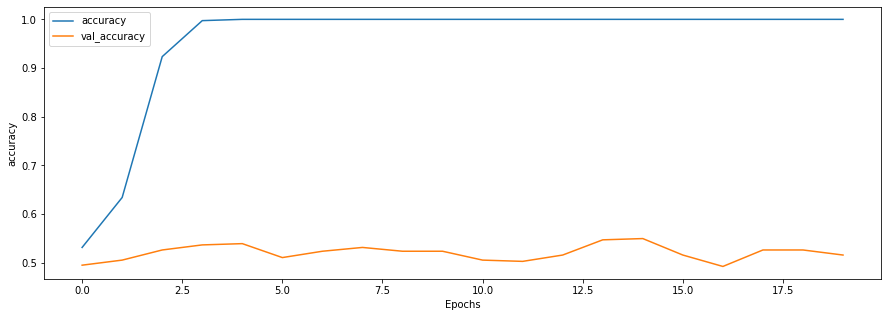

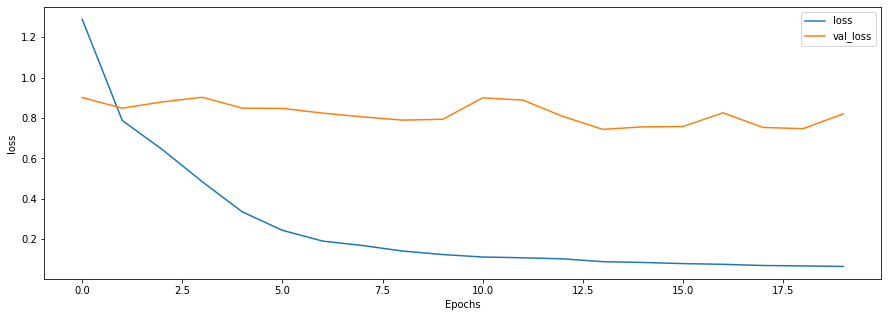

In [137]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### **The 2. attempt using only one LSTM/GRU layer in the model:**


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.GRU(128, dropout=0.5),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(lr=0.001)
sgd =  tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
#model.summary()

In [12]:
train_set, test_set = create_shuffled_datasets(training_padded, training_labels, test_padded, test_labels)
history = model.fit(train_set, epochs=20, validation_data=test_set, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

Epoch 1/20
24/24 - 9s - loss: 0.8465 - accuracy: 0.5352 - val_loss: 0.8224 - val_accuracy: 0.5052
Epoch 2/20
24/24 - 1s - loss: 0.7975 - accuracy: 0.5390 - val_loss: 0.7820 - val_accuracy: 0.5052
Epoch 3/20
24/24 - 1s - loss: 0.7611 - accuracy: 0.5534 - val_loss: 0.7553 - val_accuracy: 0.5052
Epoch 4/20
24/24 - 1s - loss: 0.7395 - accuracy: 0.5422 - val_loss: 0.7335 - val_accuracy: 0.5052
Epoch 5/20
24/24 - 1s - loss: 0.7221 - accuracy: 0.5416 - val_loss: 0.7211 - val_accuracy: 0.5052
Epoch 6/20
24/24 - 1s - loss: 0.7101 - accuracy: 0.5455 - val_loss: 0.7128 - val_accuracy: 0.5052
Epoch 7/20
24/24 - 1s - loss: 0.7054 - accuracy: 0.5298 - val_loss: 0.7050 - val_accuracy: 0.5052
Epoch 8/20
24/24 - 1s - loss: 0.6987 - accuracy: 0.5383 - val_loss: 0.7017 - val_accuracy: 0.5052
Epoch 9/20
24/24 - 1s - loss: 0.6909 - accuracy: 0.5547 - val_loss: 0.7038 - val_accuracy: 0.5052
Epoch 10/20
24/24 - 1s - loss: 0.6830 - accuracy: 0.5527 - val_loss: 0.7472 - val_accuracy: 0.5052
Epoch 11/20
24/24 -

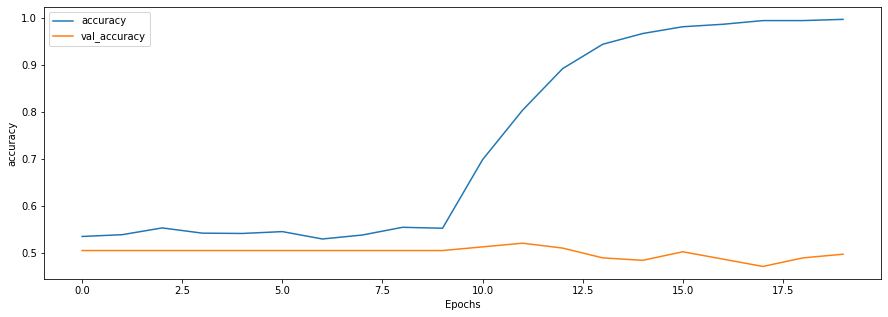

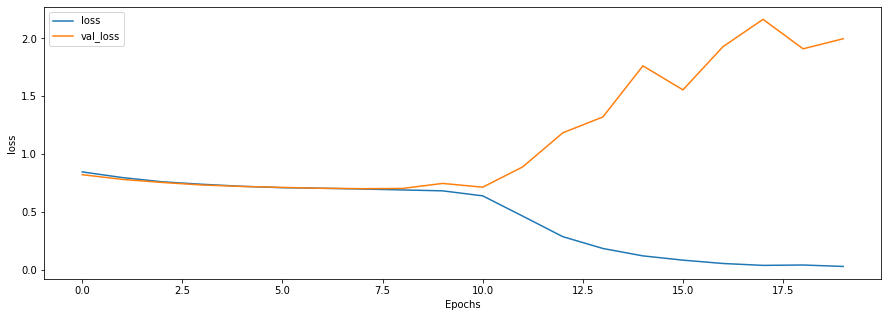

In [15]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### **The 3. attempt using 2 Convolution 1 Bidirectional LSTM layers in the model:**

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout =0.5)),#, recurrent_dropout=0.5
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
#model.summary()

In [17]:
train_set, test_set = create_shuffled_datasets(training_padded, training_labels, test_padded, test_labels)
history = model.fit(train_set, epochs=20, validation_data=test_set, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

Epoch 1/20
24/24 - 5s - loss: 0.6910 - accuracy: 0.5391 - val_loss: 0.6949 - val_accuracy: 0.5052
Epoch 2/20
24/24 - 1s - loss: 0.6872 - accuracy: 0.5390 - val_loss: 0.6932 - val_accuracy: 0.5052
Epoch 3/20
24/24 - 1s - loss: 0.6564 - accuracy: 0.6018 - val_loss: 0.6983 - val_accuracy: 0.5234
Epoch 4/20
24/24 - 1s - loss: 0.3792 - accuracy: 0.8690 - val_loss: 1.0071 - val_accuracy: 0.5026
Epoch 5/20
24/24 - 1s - loss: 0.1155 - accuracy: 0.9666 - val_loss: 1.4002 - val_accuracy: 0.5182
Epoch 6/20
24/24 - 1s - loss: 0.0289 - accuracy: 0.9961 - val_loss: 1.5623 - val_accuracy: 0.5000
Epoch 7/20
24/24 - 1s - loss: 0.0097 - accuracy: 0.9980 - val_loss: 1.7837 - val_accuracy: 0.5156
Epoch 8/20
24/24 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.8771 - val_accuracy: 0.5000
Epoch 9/20
24/24 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.9608 - val_accuracy: 0.4948
Epoch 10/20
24/24 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.9665 - val_accuracy: 0.5078
Epoch 11/20
24/24 -

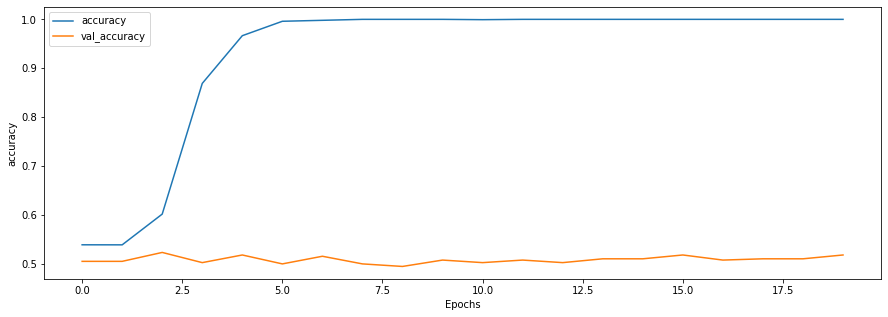

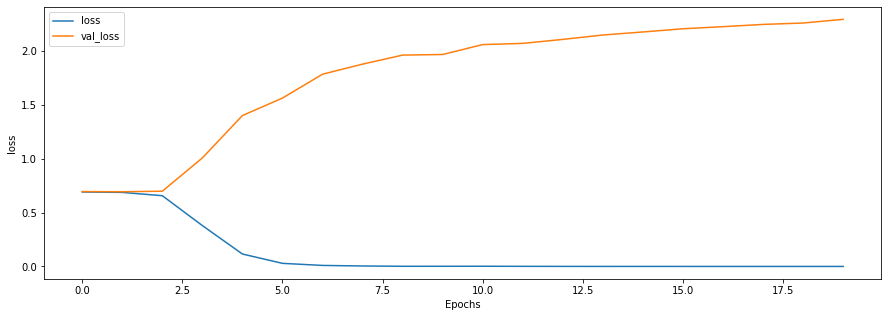

In [18]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# **Let us try pre-trained English word vectors created using the fastText library (https://fasttext.cc/docs/en/english-vectors.html)**

In [19]:
import os
import urllib.request
import zipfile
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec.zip')

# unzip files
zip_model = zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r')
zip_model.extractall('./')
zip_model.close()

**The content of wiki-news-300d-1M.vec looks as follows:**
> ....   
> day 0.0320 0.0381 -0.0299 -0.0745 -0.0624 ...    
> three 0.0304 0.0070 -0.0708 0.0689 -0.0005 ...    
> know -0.0370 -0.0138 0.0392 -0.0395 -0.1591 ...   
> ....









In [20]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [23]:
# create token-embedding mapping
embedding_matrix = np.zeros((vocab_size + 1, 300))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  if i == vocab_size:
    break
print("The shape of the embedding_matrix =", embedding_matrix.shape)

The shape of the embedding_matrix = (20001, 300)


### **The 1. attempt with DNN:**

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 300, weights=[embedding_matrix], trainable=False, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          6000300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 300)          0         
_________________________________________________________________
flatten (Flatten)            (None, 150000)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               45000300  
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                9632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [25]:
train_set, test_set = create_shuffled_datasets(training_padded, training_labels, test_padded, test_labels)
history = model.fit(train_set, epochs=30, validation_data=test_set, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

Epoch 1/30
24/24 - 2s - loss: 3.8910 - accuracy: 0.5280 - val_loss: 2.0331 - val_accuracy: 0.5052
Epoch 2/30
24/24 - 1s - loss: 1.6332 - accuracy: 0.5711 - val_loss: 1.5757 - val_accuracy: 0.5078
Epoch 3/30
24/24 - 1s - loss: 1.5014 - accuracy: 0.6745 - val_loss: 1.6004 - val_accuracy: 0.5260
Epoch 4/30
24/24 - 1s - loss: 1.4166 - accuracy: 0.8022 - val_loss: 1.9014 - val_accuracy: 0.5026
Epoch 5/30
24/24 - 1s - loss: 1.4397 - accuracy: 0.8736 - val_loss: 1.7427 - val_accuracy: 0.4870
Epoch 6/30
24/24 - 1s - loss: 1.2674 - accuracy: 0.8808 - val_loss: 1.7942 - val_accuracy: 0.4974
Epoch 7/30
24/24 - 1s - loss: 1.2090 - accuracy: 0.8874 - val_loss: 1.7653 - val_accuracy: 0.4922
Epoch 8/30
24/24 - 1s - loss: 1.0517 - accuracy: 0.9181 - val_loss: 1.8242 - val_accuracy: 0.5078
Epoch 9/30
24/24 - 1s - loss: 1.0079 - accuracy: 0.9253 - val_loss: 1.7150 - val_accuracy: 0.4974
Epoch 10/30
24/24 - 1s - loss: 0.8940 - accuracy: 0.9528 - val_loss: 1.6318 - val_accuracy: 0.4948
Epoch 11/30
24/24 -

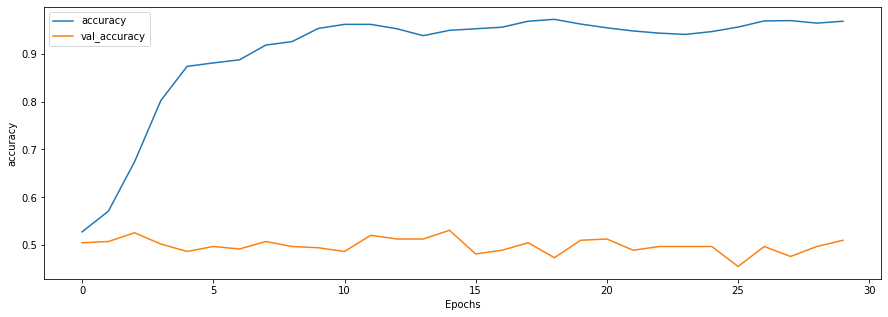

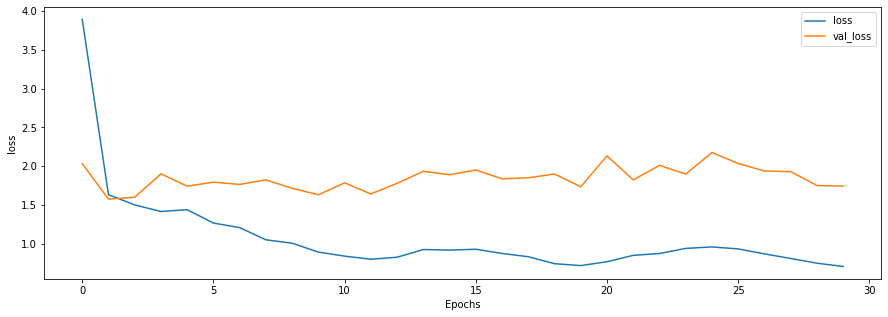

In [26]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### **The 2. attempt with convolutions and bidirectional lstmlayers:**

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 300, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout =0.5)),#, recurrent_dropout=0.5
   
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
#model.summary()

In [29]:
train_set, test_set = create_shuffled_datasets(training_padded, training_labels, test_padded, test_labels)
history = model.fit(train_set, epochs=30, validation_data=test_set, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

Epoch 1/30
24/24 - 4s - loss: 0.6957 - accuracy: 0.5137 - val_loss: 0.6951 - val_accuracy: 0.5052
Epoch 2/30
24/24 - 1s - loss: 0.6884 - accuracy: 0.5422 - val_loss: 0.6916 - val_accuracy: 0.5286
Epoch 3/30
24/24 - 1s - loss: 0.6807 - accuracy: 0.5671 - val_loss: 0.6918 - val_accuracy: 0.5312
Epoch 4/30
24/24 - 1s - loss: 0.6627 - accuracy: 0.6097 - val_loss: 0.7039 - val_accuracy: 0.5391
Epoch 5/30
24/24 - 1s - loss: 0.6095 - accuracy: 0.6758 - val_loss: 0.7703 - val_accuracy: 0.4766
Epoch 6/30
24/24 - 1s - loss: 0.5109 - accuracy: 0.7525 - val_loss: 0.8385 - val_accuracy: 0.4818
Epoch 7/30
24/24 - 1s - loss: 0.3974 - accuracy: 0.8310 - val_loss: 0.9476 - val_accuracy: 0.4948
Epoch 8/30
24/24 - 1s - loss: 0.2554 - accuracy: 0.9070 - val_loss: 1.0350 - val_accuracy: 0.5286
Epoch 9/30
24/24 - 1s - loss: 0.1720 - accuracy: 0.9299 - val_loss: 1.2359 - val_accuracy: 0.5156
Epoch 10/30
24/24 - 1s - loss: 0.1160 - accuracy: 0.9646 - val_loss: 1.3148 - val_accuracy: 0.5026
Epoch 11/30
24/24 -

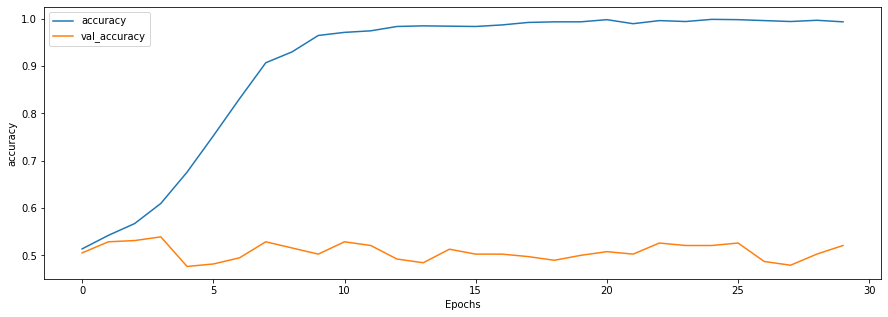

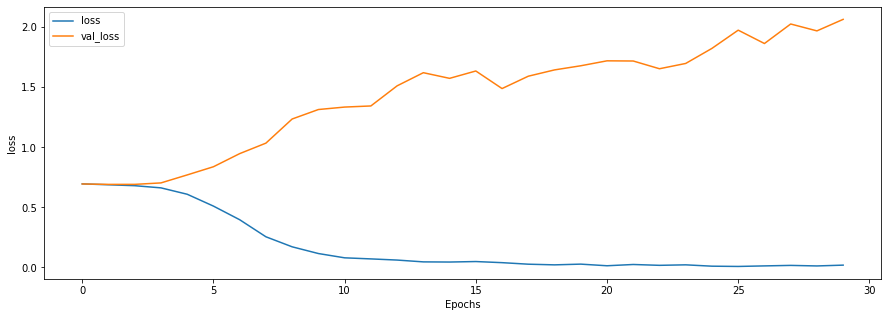

In [30]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
    #tf.keras.layers.SpatialDropout1D(0.3),
    #tf.keras.layers.Conv1D(32, 7, activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.5)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.LSTM(128, dropout=0.2, return_sequences = True),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, recurrent_dropout=0.5, return_sequences = True)),
    #tf.keras.layers.LSTM(32, dropout=0.5),
    #tf.keras.layers.GRU(64),
    #tf.keras.layers.SimpleRNN(40, return_sequences=True),
    #tf.keras.layers.SimpleRNN(40),
    #tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    #tf.keras.layers.Dropout(0.2),